In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

In [100]:
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

# サンプリング手法について

## ギブスサンプリング

In [26]:
def gibbs_sampling(mu: np.array, sigma: np.array, n: int) -> np.ndarray:
    """
    2次元正規分布のギブスサンプリングを行う．
    Args:
        mu: 平均ベクトル
        sigma: 分散共分散行列
        n: サンプル数
    Return: 2変量正規分布に従う配列
    """
    mu1 = mu[0]
    mu2 = mu[1]
    s11 = sigma[0][0]
    s22 = sigma[1][1]
    rho = sigma[0][1] / (np.sqrt(s11) * np.sqrt(s22))
    x1 = np.zeros((n))
    x2 = np.zeros((n))
    x1[0] = np.random.normal(mu1, s11)
    x2[0] = np.random.normal(mu2, s22)
    for i in range(1, n):
        x1[i] = np.random.normal(
            loc = mu1 + rho * np.sqrt(s11) * ((x2[i-1] - mu2) / np.sqrt(s22)),
            scale = s11 * (1 - rho**2)
        )
        x2[i] = np.random.normal(
            loc = mu2 + rho * np.sqrt(s22) * ((x1[i] - mu1) / np.sqrt(s11)),
            scale = s22 * (1 - rho**2)
        )
    return x1, x2

### 無相関２変量正規分布

In [4]:
mu = np.array([0, 0])
sigma = np.array([[1, 0], [0, 1]])
n = 1000
x1, x2 = gibbs_sampling(mu, sigma, n)

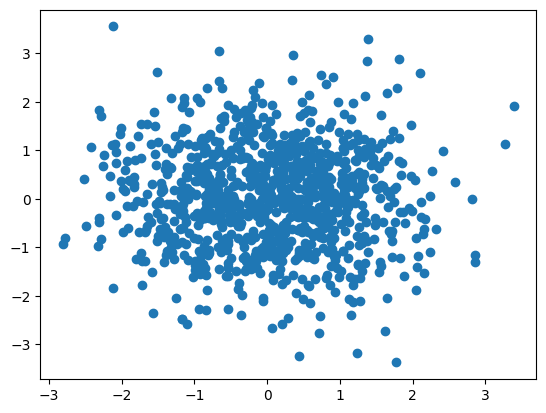

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x1,x2)

### 相関あり２変量正規分布

In [6]:
mu = np.array([0, 0])
sigma = np.array([[1, 0.8], [0.8, 1]])
n = 1000
x1, x2 = gibbs_sampling(mu, sigma, n)

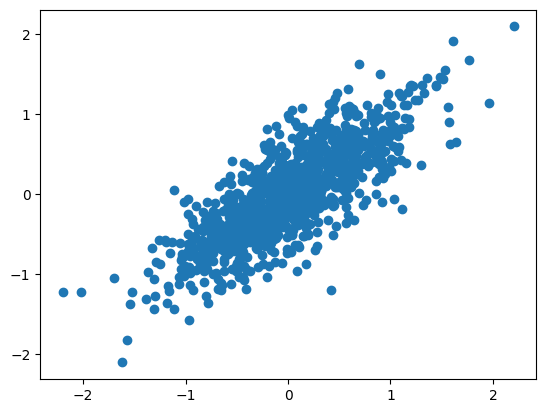

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x1,x2)

### numpyとの比較

In [9]:
np_x = np.random.multivariate_normal(mu, sigma, 1000)

#### グラフ

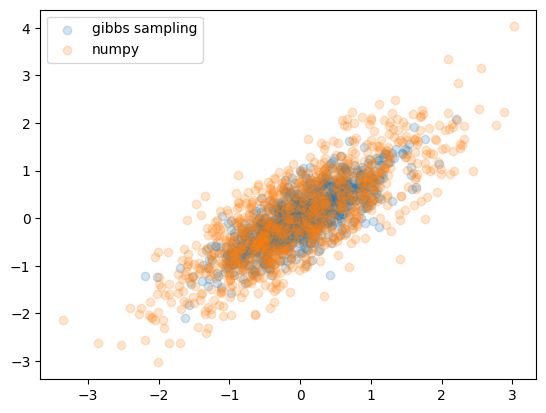

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x1, x2, label="gibbs sampling", alpha=0.2)
ax.scatter(np_x[:, 0], np_x[:, 1], label="numpy", alpha=0.2)
ax.legend()

#### 自己相関

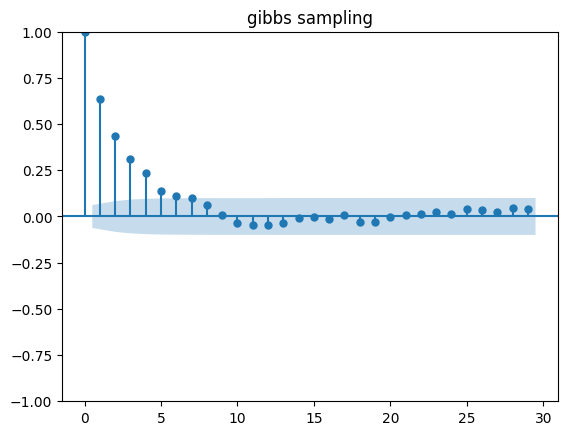

In [22]:
plot_acf(x1, lags=29)
plt.title("gibbs sampling")
plt.show()

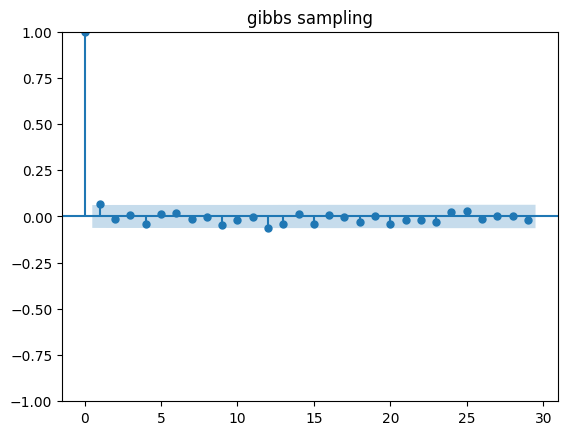

In [23]:
plot_acf(np_x[:,0 ], lags=29)
plt.title("gibbs sampling")
plt.show()

## メトロポリスヘイスティング法

In [96]:
class metropolis_hastings:
    """正規分布をメトロポリスヘイスティング法でサンプリングする."""
    def __init__(self, mu, sigma, N):
        # 実験設定
        self.mu = mu # サンプリングしたい正規分布の平均
        self.sigma = sigma # サンプリングしたい正規分布の分散
        self.N = N # 全サンプル数
        self.proposed_distribution = np.random.normal # 提案分布
        # うまくできているかの確認用
        self.cnt = 0

    def _norm_numerator(self, x):
        """正規分布の分子部分を計算する"""
        return np.exp( -(x - self.mu)**2 / (2*self.sigma**2) )

    def sampling(self):
        x = np.array([0])
        while x.shape[0] < self.N:
            # 提案分布に従ってサンプリング
            x_sample = self.proposed_distribution(x[-1], 3)
            # 棄却するかどうかを判定
            a = min(1, self._norm_numerator(x_sample)/ self._norm_numerator(x[-1]))
            if a >= np.random.rand():
                x = np.append(x, x_sample)
            else:
                pass
            self.cnt += 1
        return x

In [97]:
mu = 5
sigma = 1
N = 10000
mh = metropolis_hastings(mu, sigma, N)
x = mh.sampling()
print(f"採択率: {N / mh.cnt}")

採択率: 0.3727448933949605


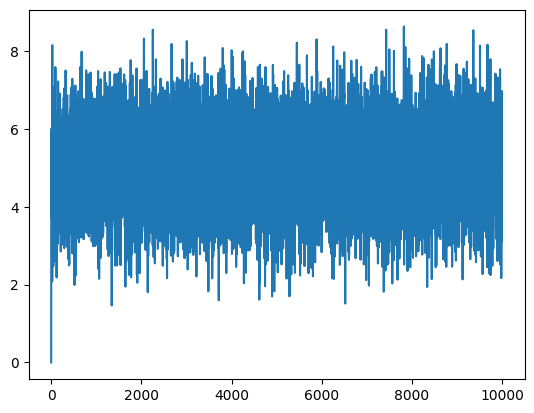

In [98]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(N), x)

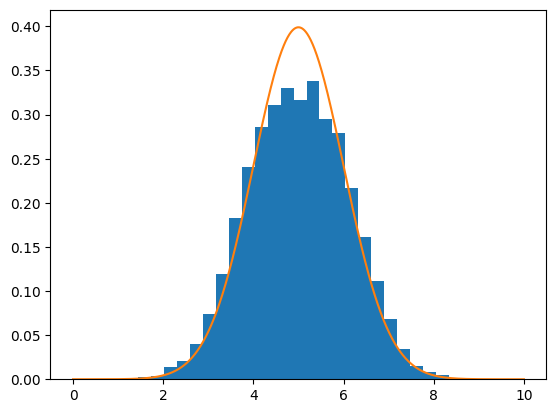

In [99]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# サンプリング結果をヒストグラムに
ax.hist(x, bins=30, density=True) 
# 目的分布の曲線をプロット
x_for_pdf = np.linspace(0, 10, 1000)
y = stats.norm.pdf(x_for_pdf, loc=mu, scale=sigma)
ax.plot(x_for_pdf, y)

((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([0.        , 0.1077707 , 1.46476603, ..., 8.54665392, 8.54672784,
         8.63091171])),
 (1.0982696287205367, 4.994544332836591, 0.9991994063405718))

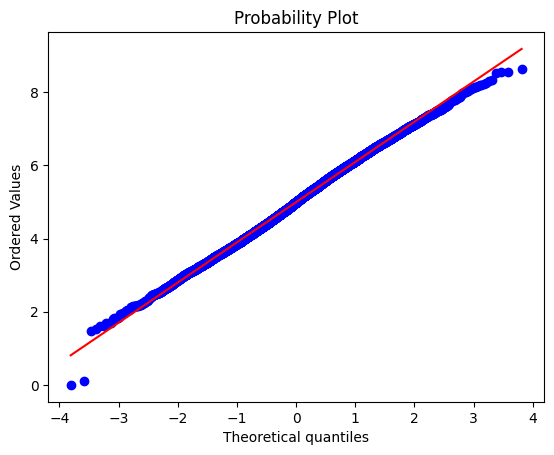

In [101]:
# QQプロット
stats.probplot(x, dist="norm", plot=plt)

# MCMCによる状態推定